In [2]:
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
from scipy import ndimage


In [3]:
df = pd.read_csv('../csvs/initial_orbital_elements.csv', index_col=0)
del df['instability_time']
del df['Rel_Eerr']
Nrows = df.shape[0]
print Nrows, len(np.where(df['Stable']==0)[0])

14999 9075


In [4]:
df_X= df.ix[:,2:]
df_Y=df['Stable']
df_X.head()

,RHill12,RHill23,beta12,beta23,m1,a1,P1,e1,pomega1,inc1,...,Omega2,f2,m3,a3,P3,e3,pomega3,inc3,Omega3,f3
0,0.026033,0.023222,8.508586,15.826967,3.414016e-05,1.0,0.999983,0.005031,3.171041,0.008978,...,1.573978,-0.567081,1.826900e-06,1.589043,2.003050,0.002515,-0.108162,0.065498,-1.192440,-0.614709
1,0.022704,0.031284,8.397002,15.367618,2.529838e-07,1.0,1.000000,0.010350,-3.564030,0.001541,...,-1.749616,1.437355,1.955797e-05,1.671403,2.160777,0.072450,-0.343874,0.046939,-0.619350,0.192203
2,0.036304,0.032149,3.461288,25.229467,7.380789e-05,1.0,0.999963,0.051912,0.995149,0.016289,...,-0.032550,-0.317958,1.477931e-07,1.936762,2.695151,0.003395,3.419165,0.014535,2.795101,1.685406
3,0.011704,0.014963,18.513681,19.145889,5.174804e-07,1.0,1.000000,0.000152,-3.328433,0.003301,...,0.946351,-2.294238,1.287851e-06,1.503164,1.842927,0.057380,-0.829096,0.098014,-2.995941,-1.625763
4,0.006199,0.008634,5.494196,2.928938,5.106746e-07,1.0,1.000000,0.001457,1.738448,0.033910,...,-0.455684,-1.074927,1.542321e-06,1.059346,1.090326,0.010325,-1.214839,0.011840,-1.253823,1.215392


In [5]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions

/mnt/raid-cita/nhussain/venv-2.7.13/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [6]:
print df_X.columns.values
model3 = XGBClassifier(seed = 3, learning_rate = 0.01, subsample = 0.9, n_estimators=225, colsample_bytree=0.75, max_depth=9, min_child_weight=4)

['RHill12' 'RHill23' 'beta12' 'beta23' 'm1' 'a1' 'P1' 'e1' 'pomega1' 'inc1'
 'Omega1' 'f1' 'm2' 'a2' 'P2' 'e2' 'pomega2' 'inc2' 'Omega2' 'f2' 'm3' 'a3'
 'P3' 'e3' 'pomega3' 'inc3' 'Omega3' 'f3']


In [8]:
from random import random, uniform , seed
import rebound

#Use to get randomly generated samples 

def sample_random(seed_val=0):
    a1 = 1. # All distances in units of the innermost semimajor axis (always at 1)
    Mstar = 1. # All masses in units of stellar mass

    logMmin = np.log10(1.e-7) # 1/3 Mars around Sun
    logMmax = np.log10(1.e-4) # 2 Nep around Sun
    logincmin = np.log10(1.e-3)
    logincmax = np.log10(1.e-1) # max mutual inclination of 11.4 degrees. Absolute of 5.7 deg
    seed(seed_val)
    
    
    M1 = 10.**uniform(logMmin, logMmax)
    M2 = 10.**uniform(logMmin, logMmax)
    M3 = 10.**uniform(logMmin, logMmax)
    
    betamin = 1.
    betamax = 30.
    
    hill12 = a1*((M1+M2)/3.)**(1./3.)
    beta1 = uniform(betamin, betamax)
    a2 = a1 + beta1*hill12

    hill23 = a2*((M2+M3)/3.)**(1./3.)
    beta2 = uniform(betamin, betamax)
    a3 = a2 + beta2*hill23

    minhill = min(hill12, hill23)

    ecrit1 = (a2-a1)/a1
    ecrit21 = (a2-a1)/a2
    ecrit23 = (a3-a2)/a2
    ecrit3 = (a3-a2)/a3
    
    logemax1 = np.log10(ecrit1)
    logemax2 = np.log10(min(ecrit21, ecrit23))
    logemax3 = np.log10(ecrit3)

    logemin1 = np.log10(M2/ecrit1**2)
    logemin2 = np.log10(max(M1/ecrit21**2, M3/ecrit23**2))
    logemin3 = np.log10(M2/ecrit3**2)
    
    e1 = min(10.**uniform(logemin1, logemax1), 1.) # make sure ecc < 1
    e2 = min(10.**uniform(logemin2, logemax2), 1.)
    e3 = min(10.**uniform(logemin3, logemax3), 1.)

    i1 = 10.**uniform(logincmin, logincmax)
    i2 = 10.**uniform(logincmin, logincmax)
    i3 = 10.**uniform(logincmin, logincmax)
    
    pomega1=random()*2.*np.pi
    Omega1=random()*2.*np.pi
    
    pomega2=random()*2.*np.pi
    Omega2=random()*2.*np.pi
    
    pomega3=random()*2.*np.pi
    Omega3=random()*2.*np.pi
    
    f1=random()*2.*np.pi # # true anomaly 
    f2=random()*2.*np.pi # # true anomaly 
    f3=random()*2.*np.pi # # true anomaly 
   

    G = 4*np.pi**2
    p1 = (a1**3 *4*np.pi**2 /G/(M1+Mstar))**0.5
    p2 = (a2**3 *4*np.pi**2 /G/(M2+Mstar))**0.5
    p3 = (a3**3 *4*np.pi**2 /G/(M3+Mstar))**0.5
        
    #print p1, p2, p3
    
    
    return [hill12, hill23, beta1, beta2, M1, a1, p1, e1, pomega1, i1, Omega1, f1, M2, a2, p2, 
            e2, pomega2, i2, Omega2, f2, M3, a3, p3, e3, pomega3, i3, Omega3, f3]

In [9]:
##sample over the entire parameter space
NumSamples = 1000000
planets_data = np.zeros((NumSamples, 28)) #= sample_random()
print planets_data.shape[0]
for i in range(NumSamples):
    planets_data[i, :] = sample_random(i+3452367)
    if (i%10000 == 9999):
        print i

1000000
9999
19999
29999
39999
49999
59999
69999
79999
89999
99999
109999
119999
129999
139999
149999
159999
169999
179999
189999
199999
209999
219999
229999
239999
249999
259999
269999
279999
289999
299999
309999
319999
329999
339999
349999
359999
369999
379999
389999
399999
409999
419999
429999
439999
449999
459999
469999
479999
489999
499999
509999
519999
529999
539999
549999
559999
569999
579999
589999
599999
609999
619999
629999
639999
649999
659999
669999
679999
689999
699999
709999
719999
729999
739999
749999
759999
769999
779999
789999
799999
809999
819999
829999
839999
849999
859999
869999
879999
889999
899999
909999
919999
929999
939999
949999
959999
969999
979999
989999
999999


In [10]:
import time
start = time.time()
model1 = XGBClassifier(n_estimators=225, learning_rate=1, max_depth = 3)
x =df_X.as_matrix()
y = df_Y.as_matrix()
model1.fit(x, y)
end = time.time()
print('Evaluation time: %f' % (end - start))

Evaluation time: 25.198168


In [20]:
#SPECIFY PARAMETERS OF INTEREST
param1 = 'beta12'
param2 = 'beta23'

#keep everything relative position of the paramters we are interested in
names = list(df_X.columns.values)
pos1 =  names.index(param1)
pos2 = names.index(param2)

In [21]:
#mean_preds = np.zeros(param1.shape[0])
preds = np.zeros(NumSamples)
start = time.time()
preds = loaded_m.predict_proba(planets_data)[:,1] #stable probability
end = time.time()
print("Total prediction time: %f s" % (end - start)) 

Total prediction time: 1.129409 s


Try projecting the two parameters as the axis, and the probability as the z axis. Also try smoothing out the values before plotting it

Try again to make a messy grid, and then try again to use griddata to make it even, interpolate the predictions from it, and then reshape it to a 2d array, try convoluting it, and then try plotting it, it may work better

In [12]:
from scipy.interpolate import griddata
grid_size = 100
xi = np.linspace(planets_data[:,pos1].min(), planets_data[:,pos1].max(),num = grid_size)
yi = np.linspace(planets_data[:,pos2].min(), planets_data[:,pos2].max(),num = grid_size)
zi = griddata((planets_data[:,pos1], planets_data[:,pos2]),preds, (xi[None,:], yi[:,None]), method='nearest')
print zi.shape





(100, 100)


In [13]:
from scipy import ndimage
zi_smooth = ndimage.filters.gaussian_filter(zi, 3.5, mode = 'reflect')
#print xi.shape

In [14]:
xi_total = np.repeat(xi, grid_size)
yi_total = np.tile(yi, grid_size)
zi_smooth.reshape(1, grid_size**2)
zi_smooth_linear = zi_smooth.flatten()

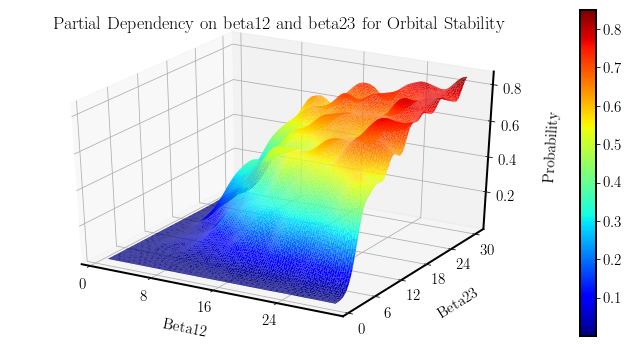

In [15]:
rc('text',usetex=True)
rc('font',family='serif')
rc('font',serif='cm')
rc('font',size=15,weight='black',stretch='extra-expanded',style='oblique')
rc('axes',linewidth=2)

fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_trisurf(xi_total, yi_total, zi_smooth_linear, cmap=cm.jet, linewidth=0)

fig.colorbar(surf)
ax.tick_params(axis='both', which='major', pad=3)

ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel('Beta12', labelpad=15)
ax.set_ylabel('Beta23', labelpad=15)
ax.set_zlabel('Probability', labelpad=15)
ax.set_title('Partial Dependency on %s and %s for Orbital Stability' % (df_X.columns[pos1],  df_X.columns[pos2]))
#ax.plot_surface(x_list, y_list, varyin_pred_mean)
#ax.ad
plt.show()

Use Inverse Distance Weighting to help interpolate specified grid points

In [16]:
def distance_matrix(x0, y0, x1, y1):
    obs = np.vstack((x0, y0)).T
    interp = np.vstack((x1, y1)).T

    # Make a distance matrix between pairwise observations
    # Note: from <http://stackoverflow.com/questions/1871536>
    d0 = np.subtract.outer(obs[:,0], interp[:,0])
    d1 = np.subtract.outer(obs[:,1], interp[:,1])

    return np.hypot(d0, d1)

In [17]:
def simple_idw(x, y, z, xi, yi):
    dist = distance_matrix(x,y, xi,yi)

    # In IDW, weights are 1 / distance
    weights = 1.0 / dist

    # Make weights sum to one
    weights /= weights.sum(axis=0)

    # Multiply the weights for each interpolated point by all observed Z-values
    zi = np.dot(weights.T, z)
    return zi

In [32]:
def plotfig(x, y, z, pos1, pos2):
    start = time.time()
    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(x, y, z, cmap=cm.jet, linewidth=0)
    fig.colorbar(surf)
    ax.tick_params(axis='both', which='major', pad=3)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))
    ax.set_xlabel(df_X.columns[pos1], labelpad=15)
    ax.set_ylabel(df_X.columns[pos2], labelpad=15)
    ax.set_zlabel('Probability', labelpad=15)
    ax.set_title('Partial Dependency on %s and %s for Orbital Stability' % (df_X.columns[pos1],  df_X.columns[pos2]))
    #ax.plot_surface(x_list, y_list, varyin_pred_mean)
    #ax.ad
    plt.show()
    end = time.time()
    print("Plotting time: %f seconds" % (end- start))

In [30]:
grid_size = 100
xi = np.linspace(planets_data[:,pos1].min(), planets_data[:,pos1].max(),num = grid_size)
yi = np.linspace(planets_data[:,pos2].min(), planets_data[:,pos2].max(),num = grid_size)
xi, yi = np.meshgrid(xi, yi)
print xi.shape
xi = xi.flatten()
yi = yi.flatten()
print xi.shape

#zi = griddata((planets_data[:,pos1], planets_data[:,pos2]),preds, (xi[None,:], yi[:,None]), method='nearest')
#print zi.shape

(100, 100)
(10000,)


In [31]:
#uneven x,uneven y, z vals, even x, even y
print planets_data[:, pos1].shape, preds.shape, xi.shape
start = time.time()
grid1 = simple_idw(planets_data[:, pos1], planets_data[:, pos2],preds, xi, yi)
end = time.time()
print("Calculating distance matrix time: %f: seconds", (end - start))

(1000000,) (1000000,) (10000,)
('Calculating distance matrix time: %f: seconds', 5348.706866979599)


In [35]:
print grid1.shape, xi.shape, yi.shape, 
#grid1_linear = grid1.reshape((grid_size, grid_size))
#print grid1_linear.shape

(10000,) (10000,) (10000,)


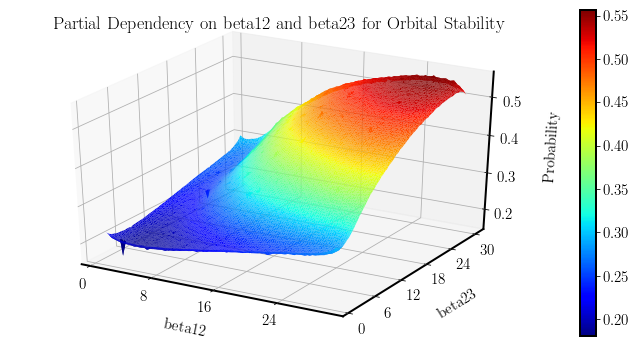

Plotting time: 11.855273 seconds


In [36]:
plotfig(xi, yi, grid1, pos1, pos2)

Try using nearest K neighbours to access the nearest values and average it, try to see if this reduces the time. (Requires rescaling of the values)

In [39]:
from scipy.spatial import cKDTree

In [213]:
#SPECIFY PARAMETERS OF INTEREST
param1 = 'e1'#'m1'#'beta12'
param2 = 'e2'#'m2'#'beta23'

#keep everything relative position of the paramters we are interested in
names = list(df_X.columns.values)
pos1 =  names.index(param1)
pos2 = names.index(param2)


import numpy as np
#data = np
#data_org = cKDTree(preds)

In [214]:
grid_size = 20

val1 = np.linspace(planets_data[:, pos1].min(), planets_data[:, pos1].max(), grid_size)
val2 = np.linspace(planets_data[:, pos2].min(), planets_data[:, pos2].max(), grid_size)
val_grid = np.zeros((grid_size, grid_size))
val_grid_count = np.zeros((grid_size, grid_size))
print val1.min(), val1.max(), val2.min(), val2.max(), 
#val_grid = val_grid.fill([]) # initalize an empyt list in each spot
#val_grid = np.frompyfunc(list,grid_size,grid_size)(val_grid)

1.56599006452e-07 1.0 6.55614261264e-07 0.477341133159


In [215]:
#for i, val in enumerate(planets_data):
bin_vals1 = np.digitize(planets_data[:, pos1],val1)
bin_vals2 = np.digitize(planets_data[:, pos2],val2)
print bin_vals1
print bin_vals1.min()
for i, val in enumerate(preds):
    val_grid[ bin_vals1[i]-1 ][bin_vals2[i]-1] += preds[i]
    val_grid_count[ bin_vals1[i]-1 ][bin_vals2[i]-1] += 1
    #val_grid[ 1 ,1] = 1
    if i%1000 == 999:
        print i
    #break

[1 2 1 ..., 1 1 1]
1
999
1999
2999
3999
4999
5999
6999
7999
8999
9999
10999
11999
12999
13999
14999
15999
16999
17999
18999
19999
20999
21999
22999
23999
24999
25999
26999
27999
28999
29999
30999
31999
32999
33999
34999
35999
36999
37999
38999
39999
40999
41999
42999
43999
44999
45999
46999
47999
48999
49999
50999
51999
52999
53999
54999
55999
56999
57999
58999
59999
60999
61999
62999
63999
64999
65999
66999
67999
68999
69999
70999
71999
72999
73999
74999
75999
76999
77999
78999
79999
80999
81999
82999
83999
84999
85999
86999
87999
88999
89999
90999
91999
92999
93999
94999
95999
96999
97999
98999
99999
100999
101999
102999
103999
104999
105999
106999
107999
108999
109999
110999
111999
112999
113999
114999
115999
116999
117999
118999
119999
120999
121999
122999
123999
124999
125999
126999
127999
128999
129999
130999
131999
132999
133999
134999
135999
136999
137999
138999
139999
140999
141999
142999
143999
144999
145999
146999
147999
148999
149999
150999
151999
152999
153999
154999
15599

In [216]:
print val_grid_count

[[  6.18294000e+05   1.06563000e+05   4.29200000e+04   2.34960000e+04
    1.41430000e+04   9.41700000e+03   6.17800000e+03   4.11500000e+03
    2.87600000e+03   2.01100000e+03   1.46500000e+03   9.60000000e+02
    6.79000000e+02   4.67000000e+02   3.04000000e+02   1.80000000e+02
    9.80000000e+01   4.60000000e+01   1.60000000e+01   0.00000000e+00]
 [  5.43200000e+04   9.22000000e+03   4.53200000e+03   2.59400000e+03
    1.54800000e+03   1.02200000e+03   6.25000000e+02   4.38000000e+02
    3.18000000e+02   1.95000000e+02   1.42000000e+02   7.60000000e+01
    7.90000000e+01   4.50000000e+01   2.70000000e+01   1.80000000e+01
    1.10000000e+01   6.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.46240000e+04   4.05600000e+03   2.01600000e+03   1.28600000e+03
    8.51000000e+02   5.73000000e+02   3.81000000e+02   2.50000000e+02
    1.61000000e+02   1.16000000e+02   9.60000000e+01   6.40000000e+01
    3.80000000e+01   2.30000000e+01   1.60000000e+01   1.20000000e+01
    6.00000000e+00

In [217]:
len(np.where(val_grid_count==0)[0])

105

In [218]:
for i in range(grid_size):
    for j in range(grid_size):
        if val_grid[i,j] !=0:
            val_grid[i,j] = val_grid[i,j]/val_grid_count[i,j]

In [219]:
print val_grid

[[  4.31835644e-01   2.42477062e-01   2.42297155e-01   2.53811364e-01
    2.14641889e-01   1.98438200e-01   1.97863095e-01   1.71611035e-01
    5.64863389e-02   5.85671420e-02   4.48815920e-02   5.72131543e-02
    5.51033176e-02   8.21447353e-02   1.16459082e-01   1.36597745e-01
    1.86609716e-01   1.57870173e-01   2.57448677e-01   0.00000000e+00]
 [  3.22716470e-01   1.94522523e-01   1.60929378e-01   1.55062805e-01
    1.20596135e-01   1.39437094e-01   1.17337097e-01   1.29904053e-01
    5.64837331e-02   4.90642049e-02   3.91466945e-02   9.27443029e-03
    3.95856071e-02   8.06078980e-02   8.79610159e-02   5.92839559e-02
    2.27690791e-01   1.81601471e-01   0.00000000e+00   0.00000000e+00]
 [  2.68007133e-01   1.57572359e-01   1.11922098e-01   1.04223730e-01
    7.16137115e-02   1.27794828e-01   9.47758090e-02   1.02346792e-01
    4.05115432e-02   2.38259632e-02   4.57613226e-02   2.15344051e-02
    2.53008491e-02   2.35208947e-02   1.76435040e-01   1.99154367e-01
    1.12839303e-01

In [220]:
val_grid_linear = val_grid.flatten()
val1_total = np.repeat(val1, grid_size)
val2_total = np.tile(val2, grid_size)

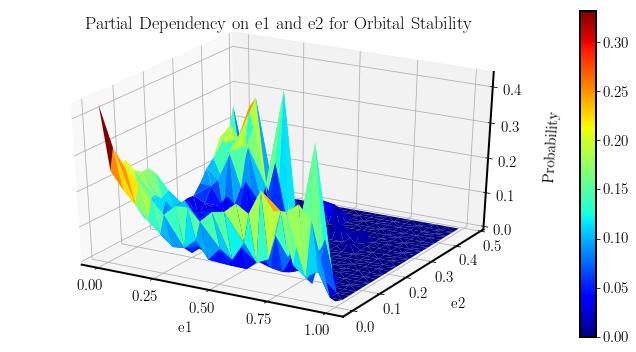

Plotting time: 1.027071 seconds


In [221]:
plotfig(val1_total, val2_total, val_grid_linear, pos1, pos2)


Try convoluting the grid to make it smoother, and then try plotting it.

In [222]:
val_grid2 = val_grid_linear.reshape(grid_size, grid_size)
val_grid2 = ndimage.filters.gaussian_filter(val_grid2, 3.5, mode = 'reflect')
val_grid_linear2 = val_grid2.flatten()

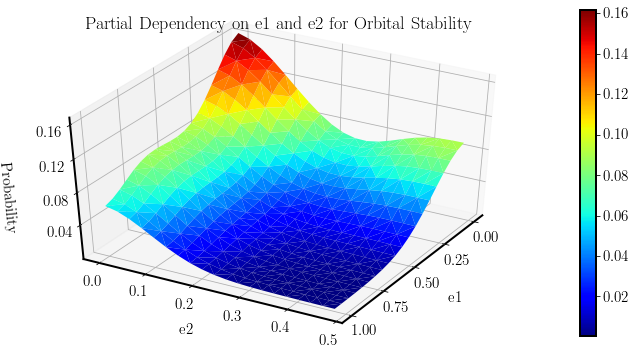

Plotting time: 2.612121 seconds


In [223]:
#plotfig(val1_total, val2_total, val_grid_linear, pos1, pos2)

start = time.time()
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_trisurf(val1_total, val2_total, val_grid_linear2, cmap=cm.jet, linewidth=0)
fig.colorbar(surf)
ax.tick_params(axis='both', which='major', pad=3)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(6))
ax.zaxis.set_major_locator(MaxNLocator(5))
ax.set_xlabel(df_X.columns[pos1], labelpad=15)
ax.set_ylabel(df_X.columns[pos2], labelpad=15)
ax.set_zlabel('Probability', labelpad=15)
ax.set_title('Partial Dependency on %s and %s for Orbital Stability' % (df_X.columns[pos1],  df_X.columns[pos2]))
#ax.plot_surface(x_list, y_list, varyin_pred_mean)
#ax.ad
ax.view_init(elev=40, azim=30)
plt.show()
end = time.time()
print("Plotting time: %f seconds" % (end- start))      


Write a function that encapusulates this functionality so that if the user enters in data, and a model, and two parameters contained within the panda frame, then it will spit out a PDP between those two parameters, as well as grid size.

In [15]:
def TwoD_PDP(X, Y, model, parameter1, parameter2, N_samples=1000000, grid_size=100 , start_seed=3452367, elev = 40, azim = 30): 
    # X, y, model, two parameters(string), num of predicted samples generated, grid size, viewing angles
    #assume the X, and Y are panda-frames with labeled features for X
    
    #requires the following imports
    #import matplotlib
    #import numpy as np
    #import pandas as pd
    #from matplotlib import pyplot as plt
    #from matplotlib import rc
    #from matplotlib import cm
    #from mpl_toolkits.mplot3d import axes3d
    #from matplotlib.ticker import MaxNLocator
    
    #Fit model
    x =X.as_matrix()
    y = Y.as_matrix()
    model.fit(x, y)
    
    print X.shape
    
    #Generate predicted samples over the entire parameter space
    NumSamples = N_samples
    planets_data = np.zeros((NumSamples, X.shape[1])) #= sample_random()
    
    print planets_data.shape
    
    for i in range(NumSamples):
        planets_data[i, :] = sample_random(i+start_seed) #use generating function
      
    #SPECIFY PARAMETERS OF INTEREST
    param1 = parameter1
    param2 = parameter2

    #keep everything relative position of the paramters we are interested in
    names = list(X.columns.values)
    pos1 =  names.index(param1)
    pos2 = names.index(param2)

    #Initialize arrays to bin data and keep track of num of values 
    val1 = np.linspace(planets_data[:, pos1].min(), planets_data[:, pos1].max(), grid_size)
    val2 = np.linspace(planets_data[:, pos2].min(), planets_data[:, pos2].max(), grid_size)
    val_grid = np.zeros((grid_size, grid_size))
    val_grid_count = np.zeros((grid_size, grid_size))

    #Bin the values
    bin_vals1 = np.digitize(planets_data[:, pos1],val1)
    bin_vals2 = np.digitize(planets_data[:, pos2],val2)
    preds = model.predict_proba(planets_data)[:, 1]
    
    for i, val in enumerate(preds):
        val_grid[ bin_vals1[i]-1 ][bin_vals2[i]-1] += preds[i]
        val_grid_count[ bin_vals1[i]-1 ][bin_vals2[i]-1] += 1
    
    #Calculate the average predictions
    for i in range(grid_size):
        for j in range(grid_size):
            if val_grid[i,j] !=0:
                val_grid[i,j] = val_grid[i,j]/val_grid_count[i,j]
                
    #Rearrange values for graphing purposes            
    val1_total = np.repeat(val1, grid_size)
    val2_total = np.tile(val2, grid_size)

    #Apply a gaussian filter
    
    val_grid2 = ndimage.filters.gaussian_filter(val_grid, 3.5, mode = 'reflect')
    val_grid_linear2 = val_grid2.flatten()

    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(val1_total, val2_total, val_grid_linear2, cmap=cm.jet, linewidth=0)
    fig.colorbar(surf)
    ax.tick_params(axis='both', which='major', pad=3)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))
    ax.set_xlabel(df_X.columns[pos1], labelpad=15)
    ax.set_ylabel(df_X.columns[pos2], labelpad=15)
    ax.set_zlabel('Probability', labelpad=15)
    ax.set_title('Partial Dependency on %s and %s for Orbital Stability' % (df_X.columns[pos1],  df_X.columns[pos2]))
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    

Try checking the method works

In [14]:
#def TwoD_PDP(X, Y, model, parameter1, parameter2 ): 
TwoD_PDP(df_X, df_Y, model1, 'e1', 'e3')

(14999, 28)
(1000000, 28)


NameError: global name 'preds' is not defined

Make a method that doesn't fit the data in the method, as that would be lengthy if you wanted several PDP plots. I will keep the prediciting in the method though, as that is very quick 

In [22]:
def TwoDim_PDP(X, Y, model, parameter1, parameter2, N_samples=1000000, grid_size=100 , start_seed=3452367, elev = 40, azim = 30): 
    # X, y, model, two parameters(string), num of predicted samples generated, grid size, viewing angles
    #assume the X, and Y are panda-frames with labeled features for X
    
    #requires the following imports
    #import matplotlib
    #import numpy as np
    #import pandas as pd
    #from matplotlib import pyplot as plt
    #from matplotlib import rc
    #from matplotlib import cm
    #from mpl_toolkits.mplot3d import axes3d
    #from matplotlib.ticker import MaxNLocator
    #from scipy import ndimage

       
    #Generate predicted samples over the entire parameter space
    NumSamples = N_samples
    planets_data = np.zeros((NumSamples, X.shape[1])) #= sample_random()
    
    print planets_data.shape
    
    for i in range(NumSamples):
        planets_data[i, :] = sample_random(i+start_seed) #use generating function
      
    #SPECIFY PARAMETERS OF INTEREST
    param1 = parameter1
    param2 = parameter2

    #keep everything relative position of the paramters we are interested in
    names = list(X.columns.values)
    pos1 =  names.index(param1)
    pos2 = names.index(param2)

    #Initialize arrays to bin data and keep track of num of values 
    val1 = np.linspace(planets_data[:, pos1].min(), planets_data[:, pos1].max(), grid_size)
    val2 = np.linspace(planets_data[:, pos2].min(), planets_data[:, pos2].max(), grid_size)
    val_grid = np.zeros((grid_size, grid_size))
    val_grid_count = np.zeros((grid_size, grid_size))

    #Bin the values
    bin_vals1 = np.digitize(planets_data[:, pos1],val1)
    bin_vals2 = np.digitize(planets_data[:, pos2],val2)
    preds = model.predict_proba(planets_data)[:, 1]
    
    for i, val in enumerate(preds):
        val_grid[ bin_vals1[i]-1 ][bin_vals2[i]-1] += preds[i]
        val_grid_count[ bin_vals1[i]-1 ][bin_vals2[i]-1] += 1
    
    #Calculate the average predictions
    for i in range(grid_size):
        for j in range(grid_size):
            if val_grid[i,j] !=0:
                val_grid[i,j] = val_grid[i,j]/val_grid_count[i,j]
                
    #Rearrange values for graphing purposes            
    val1_total = np.repeat(val1, grid_size)
    val2_total = np.tile(val2, grid_size)

    #Apply a gaussian filter
    val_grid2 = ndimage.filters.gaussian_filter(val_grid, 3.5, mode = 'reflect')
    val_grid_linear2 = val_grid2.flatten()

    fig = plt.figure(figsize = (12,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(val1_total, val2_total, val_grid_linear2, cmap=cm.jet, linewidth=0)
    fig.colorbar(surf)
    ax.tick_params(axis='both', which='major', pad=3)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))
    ax.set_xlabel(df_X.columns[pos1], labelpad=15)
    ax.set_ylabel(df_X.columns[pos2], labelpad=15)
    ax.set_zlabel('Probability', labelpad=15)
    ax.set_title('Partial Dependency on %s and %s for Orbital Stability' % (df_X.columns[pos1],  df_X.columns[pos2]))
    ax.view_init(elev=elev, azim=azim)
    plt.show()
    

In [ ]:
model = XGBClassifier(n_estimators=200, colsample_bytree=0.7, max_depth=9, min_child_weight=4)
#Fit model, then call method version without fit
x =df_X.as_matrix()
y = df_Y.as_matrix()
model.fit(x, y)

(1000000, 28)


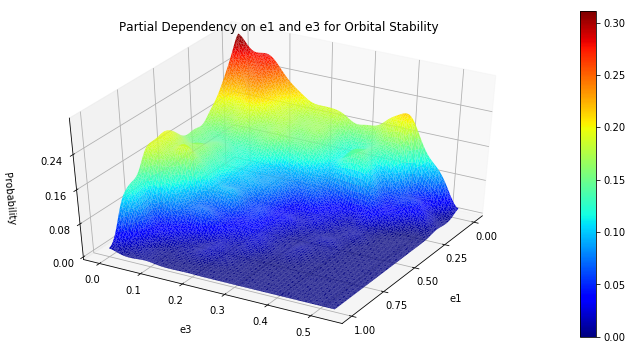

In [23]:
TwoDim_PDP(df_X, df_Y, model, 'e1', 'e3') 

In [23]:
import pickle
pickle.dump(model1 ,open("OptimalXGBmodel.pkl", 'wb'))
loaded_m = pickle.load(open('OptimalXGBmodel.pkl', 'rb'))

#model1.s
import os
statinfo = os.stat('OptimalXGBmodel.pkl')
print statinfo.st_size
#load it again

loaded_m.get_params

154615


<bound method XGBClassifier.get_params of XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=nan, n_estimators=225, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)>